<a href="https://www.kaggle.com/code/muhammadmeftahmafazy/classification?scriptVersionId=130780069" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Mengimpor *Library*

In [1]:
# feature extractoring and preprocessing data
import librosa
import librosa, librosa.display, os, csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
%matplotlib inline
import os
from PIL import Image
import pathlib
import csv

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,roc_curve,roc_auc_score, auc, plot_roc_curve
from sklearn import metrics
from sklearn.svm import SVC

#Pytorch
import torch

from imblearn.pipeline import Pipeline

import joblib

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

#Other
from IPython.display import Audio
from tqdm import tqdm

# Inisial Dataset

In [2]:
#Panggil Dataset
data = pd.read_csv("/kaggle/input/coughvid-19/dataset/data_mfcc10.csv")

In [3]:
#Menghapus kolom nama file
data_new = data.drop('filename', axis=1)

In [4]:
#Mengubah label menjadi numerik
data_new['label'].replace(['healthy', 'COVID-19'], [0,1], inplace=True)

In [5]:
# memisahkan atribut pada dataset dan menyimpannya pada sebuah variabel. 
# array ke-16 untuk dataset 10 mfcc
# array ke-26 untuk dataset 20 mfcc
# array ke-36 untuk dataset 30 mfcc
X = data_new[data_new.columns[:16]]

# array ke-24 untuk dataset 10 mfcc + ekstraksi fitur tambahan
# array ke-34 untuk dataset 20 mfcc + ekstraksi fitur tambahan
# array ke-44 untuk dataset 30 mfcc + ekstraksi fitur tambahan
# X = data_new[data_new.columns[:44]]

# memisahkan label pada dataset dan menyimpannya pada sebuah variabel
y = data_new['label']

In [6]:
# standarisasi nilai-nilai dari dataset
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

In [7]:
# Inisialisasi objek stratified k-fold dengan inisial skf
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Mencari Parameter Terbaik menggunakan algoritma GridSearchCV

In [8]:
# # Loop untuk setiap fold pada data
# for train_index, test_index in skf.split(X, y):
#     # Memisahkan data untuk training dan testing
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y[train_index], y[test_index]

# # Mencari parameter terbaik menggunakan Grid Search
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# param_grid = {'C': [0.01, 0.1, 1, 10, 100], 
#               'gamma': [0.01, 0.1, 1, 10, 100], 
#               'kernel': ['rbf'],
#              }

# clf = GridSearchCV(SVC(), param_grid, cv=skf, scoring='roc_auc')
# clf.fit(X_train_scaled, y_train)

# # Menampilkan parameter terbaik dan AUC pada data testing
# y_pred = clf.decision_function(X_test_scaled)
# auc = roc_auc_score(y_test, y_pred)

# print("Best parameters: ", clf.best_params_)
# print("AUC on test set: ", auc)

# Klasifikasi menggunakan *SVM* dengan Stratified K-Fold

In [9]:
    # Inisial variabel
    actual_class = data_new['label']
    hasil_all = np.zeros_like(actual_class)
    
    # Loop untuk setiap fold pada data
    for train_index, test_index in skf.split(X, y):
        # Memisahkan data untuk training dan testing
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Inisialisasi objek SVM
#         clf = SVC(kernel='rbf')
        clf = SVC (kernel='rbf', C=1, gamma=1, probability=True)
#         clf = SVC(kernel='rbf', C=1, gamma=0.01, probability=True)

        # Melakukan training pada model SVM
        clf.fit(X_train, y_train)

        # Melakukan prediksi pada data testing
        y_pred = clf.predict(X_test)
        hasil_all[test_index] += y_pred

        # Hitung Probabilitas
        y_prob = clf.decision_function(X_test)

# Evaluasi Model menggunakan Confusion Matrix

Confusion matrix

 [[1275  638]
 [   9    4]]

True Positives(TP) =  4

True Negatives(TN) =  1275

False Positives(FP) =  638

False Negatives(FN) =  9


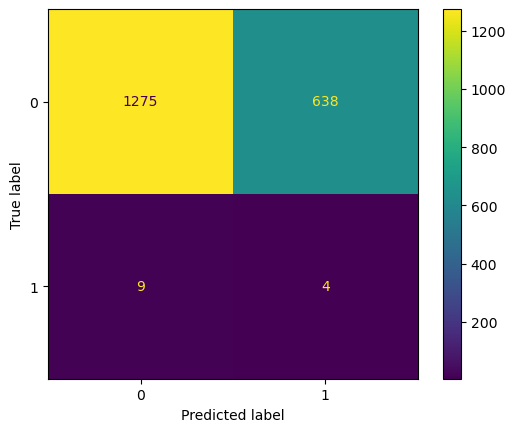

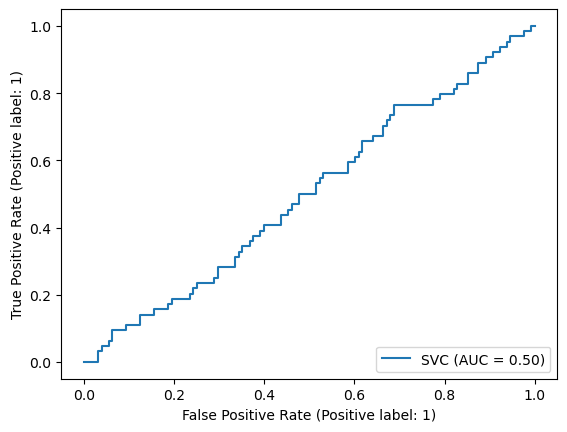

   Accuracy  Precision  Sensitivity_recall  Specificity       AUC
0  0.664071   0.006231            0.307692     0.666492  0.499268


In [10]:
    # Confusion Matrix
    results = []
    
    confusion_matrix = metrics.confusion_matrix(hasil_all, actual_class)
    print('Confusion matrix\n\n',  confusion_matrix)

    print('\nTrue Positives(TP) = ',  confusion_matrix[1,1])

    print('\nTrue Negatives(TN) = ',  confusion_matrix[0,0])

    print('\nFalse Positives(FP) = ',  confusion_matrix[0,1])

    print('\nFalse Negatives(FN) = ',  confusion_matrix[1,0])

    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = clf.classes_)

    cm_display.plot()
    plt.show()
     
    Accuracy = metrics.accuracy_score(hasil_all, actual_class)
    Precision = metrics.precision_score(hasil_all, actual_class)
    Sensitivity_recall = metrics.recall_score(hasil_all, actual_class)
    Specificity = metrics.recall_score(hasil_all, actual_class, pos_label=0)

#     print(classification_report(y_test, y_pred))
    plot_roc_curve(clf, X_test, y_test)
    plt.show()
    
    # AUC (y_prob[:,1] khusus untuk random forest dan knn)
    auc = roc_auc_score(y_test, y_prob)
#     auc = roc_auc_score(hasil_all, actual_class)
    
     # Simpan hasil ke dalam list
    results.append({'Accuracy': Accuracy,"Precision":Precision,"Sensitivity_recall":Sensitivity_recall,"Specificity":Specificity, 'AUC':auc})
    
    # Buat dataframe dari hasil
    df = pd.DataFrame(results)

    # Print dataframe
    print(df)